In [1]:
import matplotlib.pyplot as plt
import numpy as np
import csv
import pandas as pd
import torch
import torch.nn as nn
import rsample_dataset
import dataset
from torch.utils.data import DataLoader
import seaborn as sns

In [175]:
DSET_TYPE = "I"
N = 500
M = 2

# Prepare data for final evaluation of model
datafile = f'data/{DSET_TYPE}_500.pkl'
indexfile = f'indices/{DSET_TYPE}_{N}.idx'
# indexfile = f'indices/{DSET_TYPE}_{N}_train.idx'
# test_set = dataset.LazyChemDataset(datafile, indexfile, M, N, transform=AddGaussianNoise())

## Plot specific mixture loss/acc

In [117]:
with open(f"epoch_stats/{DSET_TYPE}_{N}_M{M}.csv") as f:
    reader = csv.reader(f)
    data = list(reader)
    print(f'loaded {DSET_TYPE}_{N}_M{M}.csv')

[t_losses, v_losses, t_accuracies, v_accuracies] = data
t_losses = [float(x) for x in t_losses]
v_losses = [float(x) for x in v_losses]
t_accuracies = [float(x) for x in t_accuracies]
v_accuracies = [float(x) for x in v_accuracies]

loaded I_500_M10.csv


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 15.0, 15.5, 16.0, 16.5, 17.0, 17.5, 18.0, 18.5, 19.0, 19.5, 20.0]


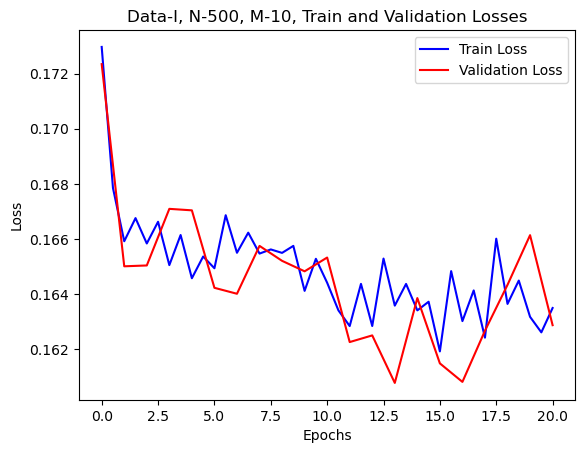

In [118]:
len_x = len(v_losses)
val_x = [i for i in range(0, len_x)]
train_x = [i/2 for i in range(0, len_x*2-1)]
print(val_x, train_x)

# Plot the train and validation losses
plt.plot(train_x,t_losses, label='Train Loss', color='blue')
plt.plot(val_x, v_losses, label='Validation Loss', color='red')

# Set labels and title for the plot
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Data-{DSET_TYPE}, N-{N}, M-{M}, Train and Validation Losses')

# Add legend and show plot
plt.legend()
plt.savefig(f'../figures/train/{DSET_TYPE}_{N}_M{M}_losses')
plt.show()



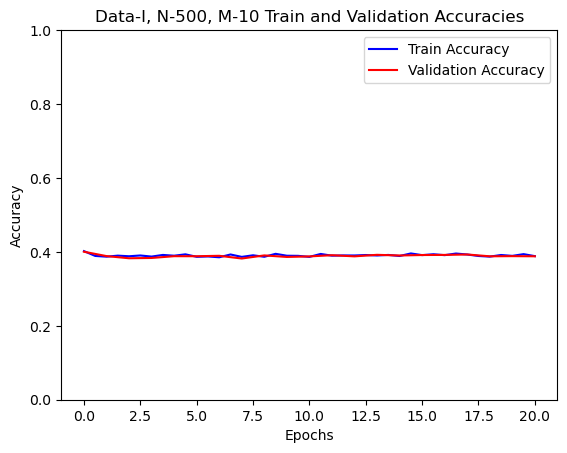

In [119]:
# Plot the train and validation accuracies
plt.plot(train_x,t_accuracies, label='Train Accuracy', color='blue')
plt.plot(val_x, v_accuracies, label='Validation Accuracy', color='red')

# Set labels and title for the plot
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title(f'Data-{DSET_TYPE}, N-{N}, M-{M} Train and Validation Accuracies')
plt.ylim(0, 1)

# Add legend and show plot
plt.legend()

plt.savefig(f'../figures/train/{DSET_TYPE}_{N}_M{M}_accuracies')

plt.show()



## M=2 Accuracy Analyses

In [194]:
CP = 1

class SimpleNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 100)
        self.fc2 = nn.Linear(100, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleNet(input_size=1781, num_classes=N)

# evaluating checkpoints
checkpoint = torch.load(f'checkpoints/{DSET_TYPE}/{DSET_TYPE}_M2_cp{CP}.pth')
model.load_state_dict(checkpoint['model_state_dict'])
acc = checkpoint['acc']
print(acc)



data = pd.read_csv(f"../data_binary.csv")

0.8125


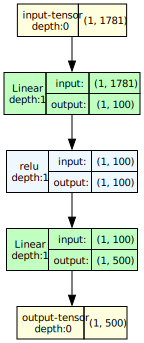

In [120]:
# visualize model
import torchvision
from torchview import draw_graph

model_graph = draw_graph(model, input_size=(1,1781), expand_nested=True)
model_graph.visual_graph

In [200]:
class AddGaussianNoise(object):
    """Add Gaussian noise to a tensor."""
    def __init__(self, mean=0.1, std=0.01):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Adds Gaussian noise to a tensor.
        """
        noise = np.random.randn(1781) * self.std + self.mean
        return tensor + noise

test_set = rsample_dataset.RSampleDataset(
    pickle_file=datafile,
    index_file=indexfile,
    n_mixture=M,
    num_classes=N,
    transform=AddGaussianNoise(),
    total_samples=5000,
)

test_set = dataset.LazyChemDataset(datafile, indexfile, M, N, transform=AddGaussianNoise())

test_loader = DataLoader(test_set, batch_size=64, shuffle=True)

In [201]:
classes = data['type'].unique()
zipped_sim_loss = []
class_losses = {(c1, c2): 0.0 for c1 in classes for c2 in classes}
class_counts = {(c1, c2): 0 for c1 in classes for c2 in classes}
class_similarities = {(c1, c2): 0.0 for c1 in classes for c2 in classes}

In [202]:
class WeightedBCEWithLogitsLoss(nn.Module):
    def __init__(self, pos_weight):
        super(WeightedBCEWithLogitsLoss, self).__init__()
        # pos_weight should be a tensor of length equal to the number of classes
        # each weight corresponds to the positive class weight for each label
        self.pos_weight = pos_weight

    def forward(self, outputs, targets):
        # Initialize BCEWithLogitsLoss with pos_weight for handling class imbalance
        criterion = nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)
        return criterion(outputs, targets)

# Assume higher weight for the positive classes due to sparsity or imbalance
pos_weight = torch.ones(N) * 10  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_function = WeightedBCEWithLogitsLoss(pos_weight=pos_weight.to(device))
model.to(device)

# accuracy function
def accuracy_fn(y_pred, y_true):
    # top_n_preds = y_pred.topk(M)[1]
    for i in range(len(y_true)):
        true_indices = y_true[i].nonzero()
        true_indices = true_indices.view(-1)
        if (len(true_indices) == 1):
            true_indices = torch.cat((true_indices, true_indices))
        # accuracy = true_indices.sort()[0].eq(top_n_preds[i].sort()[0]).sum().item()/M

        loss = loss_function(y_pred[i], y_true[i]).item()

        # calculate jaccard similarity
        x = np.array(data.iloc[true_indices[0].item(), 5:])
        y = np.array(data.iloc[true_indices[1].item(), 5:])
        intersection = np.logical_and(x, y).sum()
        union = np.logical_or(x, y).sum()
        jaccard_similarity = 0 if union == 0 else intersection/union

        # calculate dot prod similarity
        # dot_prod_similarity = np.dot(x, y)/1781


        zipped_sim_loss.append((loss, jaccard_similarity))
        # print(loss, dot_prod_similarity)

        # update class accuracies
        c1 = data.iloc[true_indices[0].item(), :]['type']
        c2 = data.iloc[true_indices[1].item(), :]['type']
        class_losses[(c1, c2)] += loss
        class_losses[(c2, c1)] += loss
        class_similarities[(c1, c2)] += jaccard_similarity
        class_similarities[(c2, c1)] += jaccard_similarity
        class_counts[(c1, c2)] += 1
        class_counts[(c2, c1)] += 1


# Accuracy measure function
def top_n_accuracy(preds, labels, n=M, correct_n=M):
    """
    Calculate the top-n accuracy for the given predictions and labels.
    """
    top_n_preds = preds.topk(n, dim=1)[1]  # Returns values and indices; [1] to get indices
    
    # Initialize the score
    score = 0.0

    for i in range(labels.size(0)):
        actual_labels = labels[i].bool()
        # select the label positions that are top n
        correct_preds = actual_labels[top_n_preds[i]].float()  
        score += correct_preds.sum().item() / correct_n

    return score


In [203]:
def test():
    running_correct = 0.0

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for data, target in test_loader:
            if not data.shape:  # Skip batches that somehow have no data
                continue
            data, target = data.to(device), target.to(device)
            outputs = model(data).squeeze(1)

            # Convert outputs to predicted labels
            predicted_probs = torch.sigmoid(outputs)
            running_correct += top_n_accuracy(predicted_probs, target)

            accuracy_fn(predicted_probs, target)

    # Calculate overall accuracy 
    accuracy = running_correct / len(test_loader.dataset)

    print(f"Overall Accuracy: {accuracy:.4f}")
    # return accuracy

In [205]:
from scipy.stats import linregress

test()

acc, sim = zip(*zipped_sim_loss)
y, x = np.array(acc), np.array(sim)


x_filtered = x[x >= 0.4]
y_filtered = y[x >= 0.4]

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x_filtered, y_filtered)

# Equation of the line
print(f"Equation of the line: y = {slope:.2f}x + {intercept:.2f}")
print(f"R-squared: {r_value**2:.3f}")

# Generate x values for the regression line for plotting
x_line = np.linspace(min(x_filtered), max(x_filtered), 100)
y_line = slope * x_line + intercept

plt.plot(x_line, y_line, color='red', label=f'y = {slope:.2f}x + {intercept:.2f}')  # plot regression line


sns.set()

plt.scatter(sim, acc, s=1)
plt.xlabel('Jaccard Similarity')
plt.ylabel('Cross-Entropy Loss')
plt.title(f'Jaccard Similarity vs Cross-Entropy Loss for {DSET_TYPE}-M2 Mixtures')
plt.savefig(f'../figures/{DSET_TYPE}_pair_similarity')


KeyboardInterrupt: 

In [206]:
test()

Overall Accuracy: 0.8155


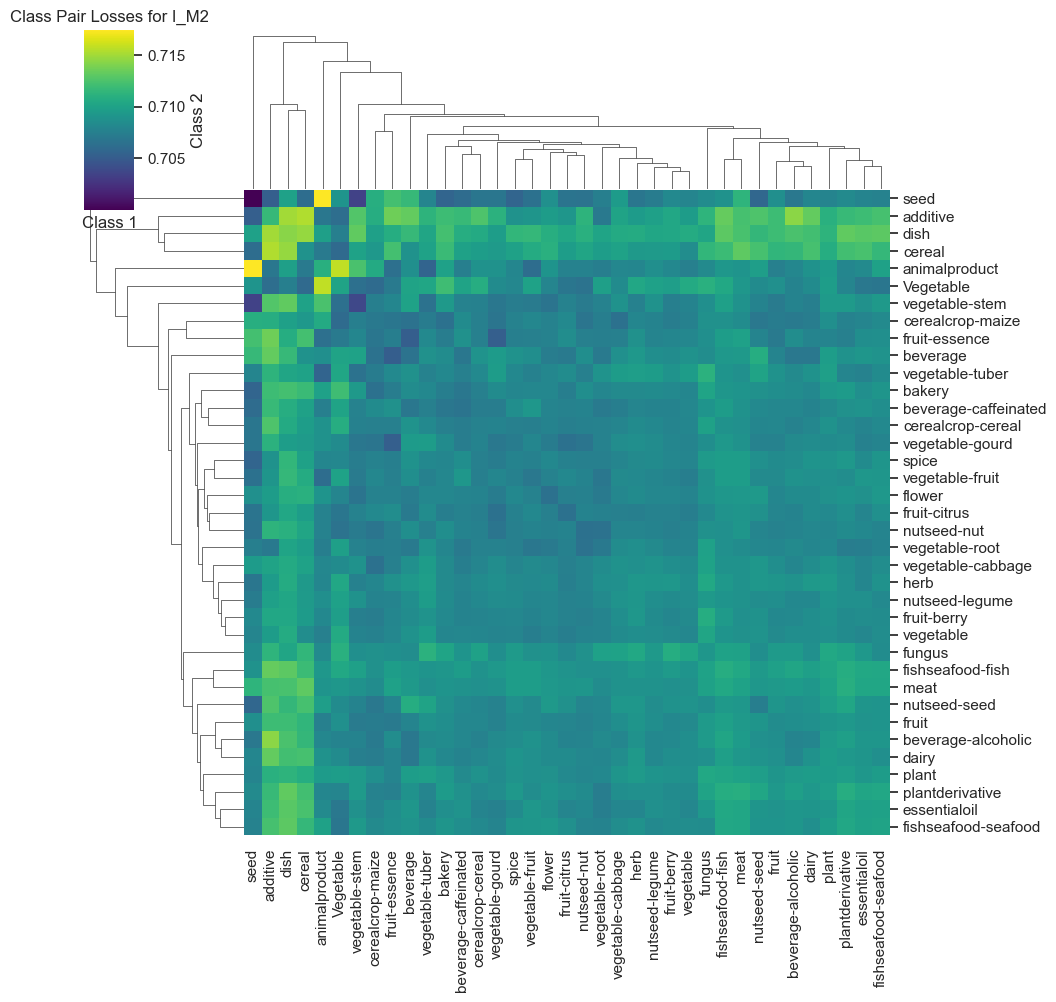

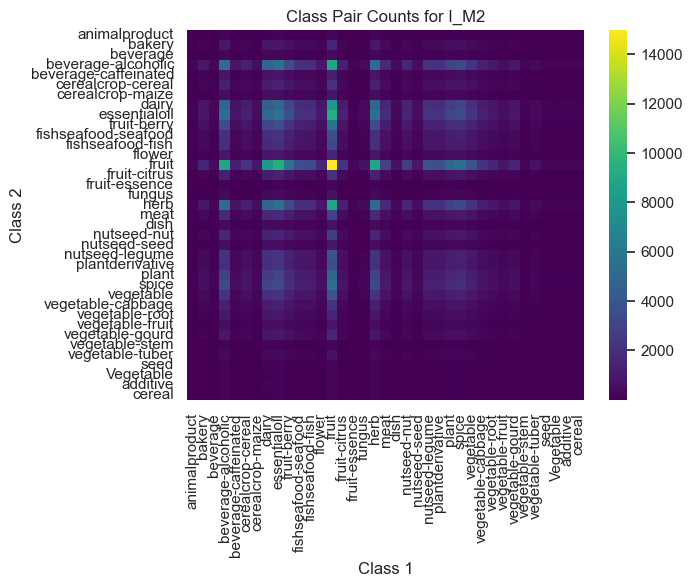

In [207]:
map_class_accuracies = np.array([[class_losses[(c1, c2)]/class_counts[(c1, c2)] for c2 in classes] for c1 in classes])
map_similarities = np.array([[class_similarities[(c1, c2)]/class_counts[(c1, c2)] for c2 in classes] for c1 in classes])
map_counts = np.array([[class_counts[(c1, c2)] for c2 in classes] for c1 in classes])

# ignore 0s in heatmap
# map_class_accuracies[map_class_accuracies == 0] = np.nan


# do hierarchical clustering
sns.clustermap(map_class_accuracies, xticklabels=classes, yticklabels=classes, cmap='viridis')
# sns.clustermap(map_similarities, xticklabels=classes, yticklabels=classes, cmap='viridis')
plt.xlabel('Class 1')
plt.ylabel('Class 2')
plt.title(f'Class Pair Losses for {DSET_TYPE}_M{M}')
plt.savefig(f'../figures/{DSET_TYPE}_pair_losses_heatmap')

plt.show()

map_similarities[map_similarities == 0] = np.nan


# heatmap for counts with numbers
sns.heatmap(map_counts, xticklabels=classes, yticklabels=classes, cmap='viridis')
plt.xlabel('Class 1')
plt.ylabel('Class 2')
plt.title(f'Class Pair Counts for {DSET_TYPE}_M{M}')
plt.savefig(f'../figures/{DSET_TYPE}_pair_counts_heatmap')
plt.show()


## Base Accuracy Analyses

In [208]:
# plot accuracy for different values of M
M_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
accuracies = [1]
for m in M_values[1:]:
    with open(f"epoch_stats/{DSET_TYPE}_{N}_M{m}.csv") as f:
        reader = csv.reader(f)
        data = list(reader)

    [_, _, _, v_accuracies] = data
    v_accuracies = [float(x) for x in v_accuracies]
    accuracies.append(v_accuracies[-1])

In [209]:
def test(m):
    # reset model weights
    model = SimpleNet(input_size=1781, num_classes=N)
    test_set_base = rsample_dataset.RSampleDataset(
        pickle_file=datafile,
        index_file=indexfile,
        n_mixture=m,
        num_classes=N,
        transform=AddGaussianNoise(),
        total_samples=5000,
    )

    # set data loader to correct m
    test_loader_base = DataLoader(test_set_base, batch_size=64, shuffle=True)

    running_correct = 0.0

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for data, target in test_loader_base:
            if not data.shape:  # Skip batches that somehow have no data
                continue
            data, target = data.to(device), target.to(device)
            outputs = model(data).squeeze(1)

            # Convert outputs to predicted labels
            predicted_probs = torch.sigmoid(outputs)
            running_correct += top_n_accuracy(predicted_probs, target, n=m, correct_n=m)

    # Calculate overall accuracy 
    accuracy = running_correct / len(test_loader.dataset)

    print(f"Overall Accuracy: {accuracy:.4f}")
    return accuracy

In [210]:
base_accuracies = []

for i in range(10):
    acc = test(i+1)
    base_accuracies.append(acc)

base_accuracies

Overall Accuracy: 0.0000
Overall Accuracy: 0.0001
Overall Accuracy: 0.0001
Overall Accuracy: 0.0002
Overall Accuracy: 0.0002
Overall Accuracy: 0.0002
Overall Accuracy: 0.0003
Overall Accuracy: 0.0003
Overall Accuracy: 0.0004
Overall Accuracy: 0.0004


[0.0,
 8.8e-05,
 0.00014266666666666667,
 0.000155,
 0.00019359999999999996,
 0.00023800000000000004,
 0.00026571428571428574,
 0.000327,
 0.000368,
 0.00042359999999999994]

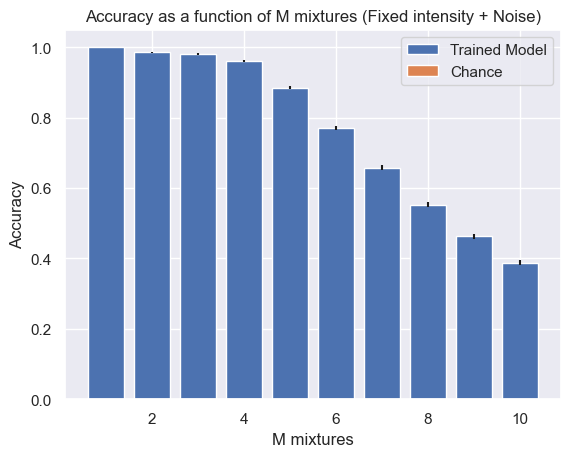

In [211]:
# overlay base accuracies on bar plot from before
# add sd bars as sqrt(p(1-p)/n) to accuracies for error bars on a bar plot
accuracies = np.array(accuracies)
std_devs = np.sqrt(accuracies*(1-accuracies)/5000)
plt.bar(M_values, accuracies, yerr=std_devs, label='Trained Model')
plt.bar([i+1 for i in range(10)], base_accuracies, label='Chance')
plt.xlabel('M mixtures')
plt.ylabel('Accuracy')
plt.title('Accuracy as a function of M mixtures (Fixed intensity + Noise)')
plt.legend()
plt.savefig(f'../figures/{DSET_TYPE}_M_accuracies_with_chance')
plt.show()


## EDA

In [5]:
odors_per_class = {}
num_per_class = {}
for i in range(len(data)):
    row = data.iloc[i]
    if row['type'] not in odors_per_class:
        odors_per_class[row['type']] = row[5:].sum()
        num_per_class[row['type']] = 1
    else:
        odors_per_class[row['type']] += row[5:].sum()
        num_per_class[row['type']] += 1
avg_odors_per_class = {k: v/num_per_class[k] for k, v in odors_per_class.items()}
avg_odors_per_class


{'animalproduct': 55.0,
 'bakery': 47.714285714285715,
 'beverage': 39.0,
 'beverage-alcoholic': 100.375,
 'beverage-caffeinated': 77.33333333333333,
 'cerealcrop-cereal': 107.0,
 'cerealcrop-maize': 79.75,
 'dairy': 93.1891891891892,
 'essentialoil': 41.0,
 'fruit-berry': 115.73076923076923,
 'fishseafood-seafood': 30.3125,
 'fishseafood-fish': 23.333333333333332,
 'flower': 61.142857142857146,
 'fruit': 116.79411764705883,
 'fruit-citrus': 102.8,
 'fruit-essence': 174.0,
 'fungus': 116.0,
 'herb': 127.75,
 'meat': 58.61538461538461,
 'dish': 3.3333333333333335,
 'nutseed-nut': 106.33333333333333,
 'nutseed-seed': 139.25,
 'nutseed-legume': 114.3529411764706,
 'plantderivative': 21.5625,
 'plant': 93.81818181818181,
 'spice': 133.12,
 'vegetable': 119.05882352941177,
 'vegetable-cabbage': 122.6,
 'vegetable-root': 125.42857142857143,
 'vegetable-fruit': 134.75,
 'vegetable-gourd': 107.57142857142857,
 'vegetable-stem': 168.0,
 'vegetable-tuber': 150.0,
 'seed': 30.0,
 'Vegetable': 104

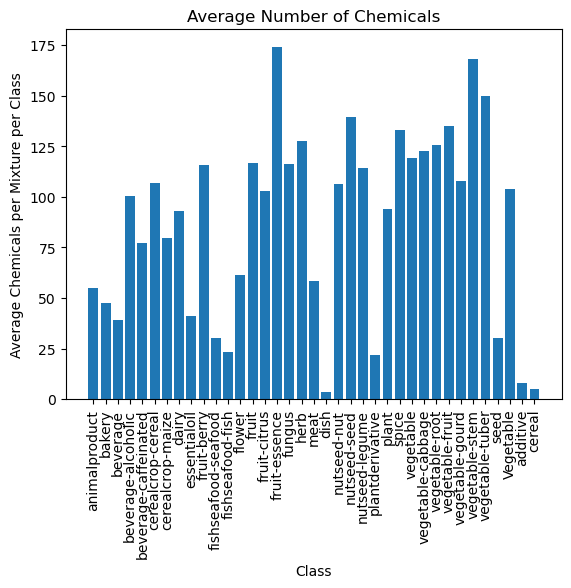

In [6]:
# bar plot of odors per class
plt.bar(avg_odors_per_class.keys(), avg_odors_per_class.values())
plt.xlabel('Class')
plt.ylabel('Average Chemicals per Mixture per Class')
plt.xticks(rotation=90)
plt.title('Average Number of Chemicals')
plt.show()


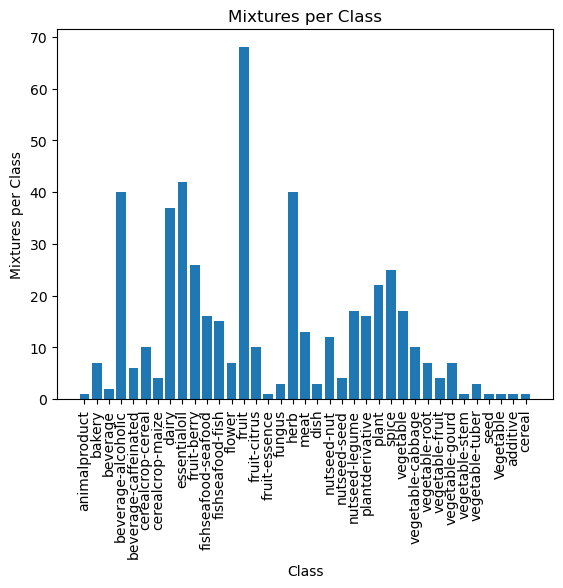

In [7]:
# bar plot of mixtures per class
plt.bar(num_per_class.keys(), num_per_class.values())
plt.xlabel('Class')
plt.ylabel('Mixtures per Class')
plt.xticks(rotation=90)
plt.title('Mixtures per Class')
plt.show()
